# Parallel KMeans implementation
Based on J. Y. Q. H. Z. W. a. J. C. Bowen Wang, “Parallelizing K-means-based Clustering on Spark,” International Conference on Advanced Cloud and Big Data, 2016. 

## Parallel partition based algorithm outline
1. Initialize centroids by randomly selecting k points from the data set. Broadcast selected centroids to all nodes
1. While centrodis still changing:
    1. For each partition do locally:
        1. For each point in partition:
            1. Compute distance to all centroids
            1. Asign closest cluster
        1. For each cluster in partition:
            1. Compute local mean
    1. Compute mean for each cluster for each partition
 

## Adaptations made to sugested implementation of the algorithm:
1. The authors suggest using SparseVector, with chosen data sets it is better to use regular arrys
1. We use random sample for centroids initialization as described in *Scalable K-Means++* because quality of inital centrods has a major effect on quality
1. We use crisp clustring only i. e. each point can be a member of one cluster only
1. We use euclidian data because it is the recommended distance function for dense data.

## Description of production cluster on Azure:
We are using Azure HDIsight in order to run a spark cluster. We are using a cluster with the following configuration:
* two master nodes Standard_D12_V2 4 CPU Cores 28GB RAM
* eight slave nodes Standard_D13_V2 8 CPU Cores 56GB RAM

In [1]:
import random 
import time
import math
import logging
import itertools
import typing
from numpy import array
import numpy as np
import pandas as pd
from scipy import spatial
import matplotlib.pyplot as plt
from pprint import pprint
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.mllib.clustering import KMeans, KMeansModel
from itertools import groupby, compress

from typing import Tuple, Sequence


sc.stop()
conf = SparkConf().set("spark.python.profile", "true")
conf.set("spark.driver.memory", "13G")
sc = SparkContext(conf=conf)

sc.setLogLevel('INFO')
# For reproducability of results
RANDOM_SEED = 301191

%matplotlib inline

sc.getConf().getAll()

[('spark.driver.memory', '13G'),
 ('spark.app.id', 'local-1631803880499'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '42949'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.python.profile', 'true'),
 ('spark.driver.host', '192.168.48.128'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.ui.showConsoleProgress', 'true')]

### Import test data and parse data set

In [2]:
data = sc.textFile("data/a3.txt")
parsed_data = data.map(lambda line: array([float(x) for x in line.strip().split()]))
parsed_data.cache()

parsed_data.take(5)

[array([53920., 42968.]),
 array([52019., 42206.]),
 array([52570., 42476.]),
 array([54220., 42081.]),
 array([54268., 43420.])]

In [3]:
parsed_data.count()

7500

In [4]:
def euclidean_dist(v1, v2):
    return np.linalg.norm(v1-v2)
    
def closest_centroid(point, centroids):
    # for dense data, we use euclidean distance
    centroid_dist_pairs = map(lambda centroid: (centroid, euclidean_dist(point, centroid)), centroids)
    return min(centroid_dist_pairs, key=lambda centroid_dist: centroid_dist[1])

def clac_mean_points_in_cluster_pandas(distances):
    # not in use. slower implementation of means calculation
    df = pd.DataFrame(distances, columns=['Point', 'Centroid', 'Distance'])
    df['Centroid'] = tuple(df['Centroid'])

    return df.groupby('Centroid')['Point'].apply(np.mean).items()

def clac_mean_points_in_cluster(distances):
    def keyfunc(item):
        return tuple(item[1])
    
    sorted_distances = sorted(distances, key=keyfunc)
    for k, g in groupby(sorted_distances, keyfunc):
        yield k, np.mean(array(list(g))[:,0], axis=0)

def calc_partition_centroid_means(partition, centroids):
    distances = map(lambda point: (point, 
                                   *closest_centroid(point, centroids)), 
                    partition)
    
    group = clac_mean_points_in_cluster(distances)
    return group

def closest_centroids_per_partition(data, centroids):
    """
    calculate local means for each centroid on each partition to avoid transfer of large volume of data
    
    @param data: rdd, the actual data set
    @param centroids:
    @return: rdd of tuples (original centroid, mean of points close to this centroid on each partition)
    """
    result = data.mapPartitions(lambda partition: calc_partition_centroid_means(partition, centroids.value))
    return result

def color_hash(point):
    hsh = int(point[0] ** 2 + point[1] ** 2)
    return '#' + str(hex(hsh % int('ffffff', 16)))[2:].zfill(6)

def calc_error(new_centroids_series: pd.DataFrame):
    old_and_new_centroids = array(list(new_centroids_series.items()))
    error = np.linalg.norm((old_and_new_centroids[:,0] - old_and_new_centroids[:,1]))
    return error

def aggregate_means(closest_centroids):
    df = pd.DataFrame(closest_centroids, columns=['Centroid', 'Point']) 
    new_centroids_series = df.groupby('Centroid')['Point'].apply(np.mean)
    return new_centroids_series

def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    centroids = sc.broadcast(init_centroids)
    
    iteration = 1
    error = True
    while error > stop_distance and iteration <= max_iterations:
        loop_start = time.time()
        closest_centroids_rdd = closest_centroids_per_partition(data, centroids)
        closest_centroids = closest_centroids_rdd.collect()
        new_centroids_series = aggregate_means(closest_centroids)
        error = calc_error(new_centroids_series)
        print("Iteration #{0}\tDistance between old and new centroids: {1:.4f}\tIteration took: {2:.4f} sec".format(
                                                                iteration, error, time.time() - loop_start))
        centroids = sc.broadcast(new_centroids_series.to_list())
        iteration += 1
    
    return new_centroids_series.to_list()
    

In [5]:
final_centroids = pkmeans(parsed_data, 50)

### Run profiler to see what slows down

In [6]:
%load_ext line_profiler

In [7]:
def test_porfile():
    pkmeans(parsed_data, 50)

In [8]:
%lprun -f pkmeans test_porfile()

```
Timer unit: 1e-06 s

Total time: 27.4172 s
File: <ipython-input-150-1dd397ddc730>
Function: pkmeans at line 56

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    56                                           def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    57         1     101992.0 101992.0      0.4      init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    58         1       2476.0   2476.0      0.0      centroids = sc.broadcast(init_centroids)
    59                                               
    60         1          1.0      1.0      0.0      iteration = 1
    61         1          0.0      0.0      0.0      error = True
    62        20         47.0      2.4      0.0      while error > stop_distance and iteration <= max_iterations:
    63        19         27.0      1.4      0.0          loop_start = time.time()
    64        19        435.0     22.9      0.0          closest_centroids_rdd = closest_centroids_per_partition(data, centroids)
    65        19   26590086.0 1399478.2     97.0          closest_centroids = closest_centroids_rdd.collect()
    66        19     648951.0  34155.3      2.4          new_centroids_series = aggregate_means(closest_centroids)
    67        19       3301.0    173.7      0.0          error = calc_error(new_centroids_series)
    68        19         34.0      1.8      0.0          print("Iteration #{0}\tDistance between old and new centroid: {1:.4f}\tIteration took: {2:.4f} sec".format(
    69        19       3429.0    180.5      0.0                                                                  iteration, error, time.time() - loop_start))
    70        19      66310.0   3490.0      0.2          centroids = sc.broadcast(new_centroids_series.to_list())
    71        19         32.0      1.7      0.0          iteration += 1
    72                                               
    73         1         33.0     33.0      0.0      return new_centroids_series.to_list()
 ```

__We can see that most time is spent on computation of closest_centroids_rdd.__ <br>
__Now, we will turn on the spark profiler to see what takes the most time__

In [9]:
sc.show_profiles()

Profile of RDD<id=2>
         97716 function calls in 0.068 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       24    0.025    0.001    0.025    0.001 {built-in method _pickle.dumps}
     7500    0.012    0.000    0.012    0.000 {built-in method numpy.array}
        2    0.006    0.003    0.068    0.034 serializers.py:267(dump_stream)
     7500    0.005    0.000    0.022    0.000 <ipython-input-2-706b0873297e>:2(<lambda>)
     7502    0.004    0.000    0.010    0.000 serializers.py:555(loads)
     7500    0.003    0.000    0.003    0.000 <ipython-input-2-706b0873297e>:2(<listcomp>)
     7502    0.003    0.000    0.004    0.000 serializers.py:592(read_int)
     7500    0.002    0.000    0.024    0.000 util.py:105(wrapper)
     7502    0.002    0.000    0.012    0.000 serializers.py:564(load_stream)
    15002    0.001    0.000    0.001    0.000 {method 'read' of '_io.BufferedReader' objects}
     7502    0

```
============================================================
Profile of RDD<id=7>
============================================================
         6135955 function calls (5760955 primitive calls) in 4.590 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   375000    1.419    0.000    2.767    0.000 linalg.py:2316(norm)
750055/375055    0.679    0.000    3.022    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   375000    0.619    0.000    3.914    0.000 <ipython-input-3-fc001fb89f2d>:1(euclidean_dist)
     7500    0.304    0.000    4.418    0.001 {built-in method builtins.min}
   375000    0.239    0.000    0.239    0.000 {method 'ravel' of 'numpy.ndarray' objects}
   375000    0.228    0.000    3.295    0.000 <__array_function__ internals>:2(norm)
   375000    0.215    0.000    0.700    0.000 <__array_function__ internals>:2(dot)
   382610    0.146    0.000    0.146    0.000 {built-in method numpy.array}
   375000    0.143    0.000    4.056    0.000 <ipython-input-3-fc001fb89f2d>:6(<lambda>)
   375000    0.101    0.000    0.219    0.000 _asarray.py:16(asarray)
   750110    0.099    0.000    0.099    0.000 {built-in method builtins.issubclass}
   375000    0.091    0.000    0.138    0.000 linalg.py:121(isComplexType)
   375000    0.058    0.000    0.058    0.000 <ipython-input-3-fc001fb89f2d>:7(<lambda>)
   375000    0.054    0.000    0.054    0.000 multiarray.py:707(dot)
   375000    0.051    0.000    0.051    0.000 linalg.py:2312(_norm_dispatcher)
        2    0.016    0.008    4.567    2.284 {built-in method builtins.sorted}
     7500    0.014    0.000    0.055    0.000 <ipython-input-2-1ef6232a3f15>:2(<lambda>)
     7502    0.014    0.000    0.039    0.000 serializers.py:684(loads)
    15000    0.013    0.000    0.013    0.000 <ipython-input-3-fc001fb89f2d>:17(keyfunc)
     7500    0.011    0.000    4.438    0.001 <ipython-input-3-fc001fb89f2d>:25(<lambda>)
     7500    0.010    0.000    0.010    0.000 <ipython-input-2-1ef6232a3f15>:2(<listcomp>)
     7500    0.009    0.000    4.427    0.001 <ipython-input-3-fc001fb89f2d>:4(closest_centroid)
     7502    0.009    0.000    0.018    0.000 serializers.py:721(read_int)
     7502    0.007    0.000    0.045    0.000 serializers.py:693(load_stream)
    15002    0.006    0.000    0.006    0.000 {method 'read' of '_io.BufferedReader' objects}
     7500    0.006    0.000    0.061    0.000 util.py:97(wrapper)
       55    0.006    0.000    0.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     7500    0.005    0.000    0.005    0.000 {method 'decode' of 'bytes' objects}
     7502    0.005    0.000    0.005    0.000 {built-in method _struct.unpack}
     7500    0.004    0.000    0.004    0.000 {method 'split' of 'str' objects}
       57    0.004    0.000    4.587    0.080 <ipython-input-3-fc001fb89f2d>:16(clac_mean_points_in_cluster)
     7500    0.002    0.000    0.002    0.000 {method 'strip' of 'str' objects}
        2    0.001    0.001    4.589    2.295 serializers.py:396(dump_stream)
       10    0.001    0.000    0.001    0.000 {built-in method _pickle.dumps}
       55    0.001    0.000    0.006    0.000 _methods.py:134(_mean)
        2    0.000    0.000    0.000    0.000 {built-in method _pickle.load}
       55    0.000    0.000    0.006    0.000 fromnumeric.py:3231(mean)
       55    0.000    0.000    0.000    0.000 _methods.py:50(_count_reduce_items)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
       55    0.000    0.000    0.007    0.000 <__array_function__ internals>:2(mean)
      110    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        2    0.000    0.000    0.001    0.000 broadcast.py:123(load_from_path)
        2    0.000    0.000    4.590    2.295 worker.py:370(process)
       55    0.000    0.000    0.000    0.000 _asarray.py:88(asanyarray)
       10    0.000    0.000    0.000    0.000 serializers.py:728(write_int)
       10    0.000    0.000    0.001    0.000 serializers.py:582(dumps)
        2    0.000    0.000    0.001    0.000 broadcast.py:135(value)
        2    0.000    0.000    0.000    0.000 broadcast.py:127(load)
       20    0.000    0.000    0.000    0.000 {method 'write' of '_io.BufferedWriter' objects}
       55    0.000    0.000    0.000    0.000 fromnumeric.py:3227(_mean_dispatcher)
        2    0.000    0.000    0.001    0.000 <ipython-input-3-fc001fb89f2d>:40(<lambda>)
       10    0.000    0.000    0.000    0.000 {built-in method _struct.pack}
        2    0.000    0.000    0.001    0.000 rdd.py:2498(pipeline_func)
        2    0.000    0.000    0.000    0.000 rdd.py:323(func)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        2    0.000    0.000    0.001    0.000 rdd.py:351(func)
       20    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        2    0.000    0.000    0.000    0.000 <ipython-input-3-fc001fb89f2d>:24(calc_partition_centroid_means)
        2    0.000    0.000    0.000    0.000 util.py:92(fail_on_stopiteration)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
        2    0.000    0.000    0.000    0.000 {built-in method gc.enable}
        2    0.000    0.000    0.000    0.000 {built-in method gc.disable}
        2    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

```

__We can see that most of the time is spent on calculation in numpy, python is a slower language__


__Most of the time is taken by p.linalg.norm__

__We will try to change the euqlidian distnce funution to use scipy module__

In [10]:
from scipy.spatial import distance

def euclidean_dist(v1, v2):
    return distance.euclidean(v1, v2)

pkmeans(parsed_data, 50)
sc.show_profiles()

```
============================================================
Profile of RDD<id=76>
============================================================
         97562104 function calls (96062104 primitive calls) in 86.889 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   750000   11.313    0.000   33.786    0.000 arrayprint.py:863(fillFormat)
  1500000   10.916    0.000   75.867    0.000 {built-in method builtins.print}
  1875055    5.186    0.000    5.186    0.000 {method 'reduce' of 'numpy.ufunc' objects}
2250000/750000    5.138    0.000   13.491    0.000 arrayprint.py:718(recurser)
  2999800    4.278    0.000    4.278    0.000 {built-in method numpy.core._multiarray_umath.dragon4_positional}
  1500000    3.971    0.000    6.233    0.000 arrayprint.py:947(__call__)
   750000    2.623    0.000   57.050    0.000 arrayprint.py:478(_array2string)
  2249850    2.198    0.000    4.214    0.000 arrayprint.py:913(<genexpr>)
   750000    2.107    0.000   39.790    0.000 arrayprint.py:409(_get_format_function)
  1500000    1.912    0.000    4.518    0.000 _ufunc_config.py:32(seterr)
   750000    1.815    0.000   64.082    0.000 arrayprint.py:516(array2string)
  1500000    1.668    0.000    6.021    0.000 fromnumeric.py:70(_wrapreduction)
   750000    1.559    0.000   35.645    0.000 arrayprint.py:836(__init__)
  1500000    1.495    0.000    1.629    0.000 _ufunc_config.py:132(geterr)
   750000    1.474    0.000   59.129    0.000 arrayprint.py:461(wrapper)
   750000    1.342    0.000    2.672    0.000 arrayprint.py:60(_make_options_dict)
 18000146    1.264    0.000    1.264    0.000 {built-in method builtins.len}
  2250055    1.233    0.000    9.821    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   375000    1.233    0.000    9.323    0.000 distance.py:454(minkowski)
  1500000    1.113    0.000    1.433    0.000 arrayprint.py:695(_extendLine)
  2250050    1.091    0.000    2.017    0.000 {built-in method builtins.max}
   375000    1.082    0.000    4.315    0.000 misc.py:17(norm)
  2249850    1.067    0.000    5.594    0.000 arrayprint.py:918(<genexpr>)
   750000    1.023    0.000    1.023    0.000 arrayprint.py:358(_get_formatdict)
   750000    0.983    0.000    3.775    0.000 distance.py:326(_validate_vector)
   375000    0.928    0.000    2.842    0.000 function_base.py:422(asarray_chkfinite)
   750000    0.873    0.000    0.873    0.000 {built-in method builtins.locals}
   750000    0.869    0.000   64.951    0.000 arrayprint.py:1473(_array_str_implementation)
   375000    0.843    0.000   86.276    0.000 <ipython-input-39-e8707e66c8fb>:3(euclidean_dist)
   750000    0.794    0.000    1.262    0.000 shape_base.py:24(atleast_1d)
   750000    0.775    0.000    4.710    0.000 fromnumeric.py:2589(amax)
   750000    0.726    0.000   36.372    0.000 arrayprint.py:366(<lambda>)
  2625110    0.725    0.000    0.725    0.000 {built-in method numpy.array}
  1500000    0.691    0.000    0.691    0.000 {built-in method numpy.seterrobj}
   750000    0.656    0.000   14.148    0.000 arrayprint.py:709(_formatArray)
   750000    0.526    0.000    2.613    0.000 fromnumeric.py:2714(amin)
   750000    0.488    0.000    5.774    0.000 <__array_function__ internals>:2(amax)
  1500000    0.486    0.000    0.486    0.000 fromnumeric.py:71(<dictcomp>)
   750000    0.481    0.000    3.417    0.000 _ufunc_config.py:433(__enter__)
   750000    0.457    0.000    2.039    0.000 _ufunc_config.py:438(__exit__)
  1875000    0.448    0.000    1.018    0.000 _asarray.py:14(asarray)
  3000000    0.421    0.000    0.421    0.000 {built-in method numpy.geterrobj}
   750000    0.402    0.000    2.149    0.000 <__array_function__ internals>:2(atleast_1d)
  2249850    0.389    0.000    0.520    0.000 arrayprint.py:922(<genexpr>)
   750000    0.373    0.000    0.373    0.000 arrayprint.py:65(<dictcomp>)
   750000    0.352    0.000    3.416    0.000 <__array_function__ internals>:2(amin)
     7500    0.332    0.000   86.822    0.012 {built-in method builtins.min}
  1500000    0.313    0.000    0.313    0.000 {method 'split' of 'str' objects}
  2249850    0.310    0.000    0.406    0.000 arrayprint.py:923(<genexpr>)
  3000110    0.288    0.000    0.288    0.000 {built-in method builtins.issubclass}
   750000    0.253    0.000    0.253    0.000 _ufunc_config.py:429(__init__)
   375000    0.244    0.000    9.567    0.000 distance.py:578(euclidean)
  2250000    0.239    0.000    0.239    0.000 {method 'items' of 'dict' objects}
   375000    0.237    0.000    0.391    0.000 blas.py:370(getter)
   750000    0.214    0.000    0.214    0.000 {method 'update' of 'dict' objects}
   375000    0.209    0.000    1.769    0.000 {method 'all' of 'numpy.ndarray' objects}
   750000    0.204    0.000    0.204    0.000 {method 'discard' of 'set' objects}
   750000    0.193    0.000    0.193    0.000 {method 'squeeze' of 'numpy.ndarray' objects}
   750000    0.184    0.000    0.184    0.000 {method 'copy' of 'dict' objects}
   750055    0.169    0.000    0.318    0.000 _asarray.py:86(asanyarray)
   750110    0.157    0.000    0.157    0.000 {built-in method builtins.isinstance}
   375000    0.154    0.000    0.154    0.000 {method 'get' of 'dict' objects}
   375000    0.144    0.000   86.420    0.000 <ipython-input-33-e15f9ffbec71>:6(<lambda>)
   750000    0.144    0.000    0.144    0.000 arrayprint.py:827(_none_or_positive_arg)
   750000    0.140    0.000    0.140    0.000 {built-in method builtins.id}
   750000    0.138    0.000    0.138    0.000 {method 'add' of 'set' objects}
   750000    0.133    0.000    0.133    0.000 {method 'rstrip' of 'str' objects}
   750000    0.124    0.000    0.124    0.000 {built-in method _thread.get_ident}
   750000    0.110    0.000    0.110    0.000 fromnumeric.py:2584(_amax_dispatcher)
   750000    0.091    0.000    0.091    0.000 fromnumeric.py:2709(_amin_dispatcher)
   375000    0.090    0.000    1.560    0.000 _methods.py:56(_all)
   750000    0.083    0.000    0.083    0.000 {method 'append' of 'list' objects}
   750000    0.080    0.000    0.080    0.000 shape_base.py:20(_atleast_1d_dispatcher)
   375000    0.070    0.000    0.070    0.000 <ipython-input-33-e15f9ffbec71>:7(<lambda>)
    15000    0.011    0.000    0.011    0.000 <ipython-input-33-e15f9ffbec71>:17(keyfunc)
     7500    0.011    0.000   86.843    0.012 <ipython-input-33-e15f9ffbec71>:25(<lambda>)
     7500    0.010    0.000   86.832    0.012 <ipython-input-33-e15f9ffbec71>:4(closest_centroid)
        2    0.010    0.005   86.869   43.435 {built-in method builtins.sorted}
     7600    0.003    0.000    0.003    0.000 {method 'reshape' of 'numpy.ndarray' objects}
       24    0.003    0.000    0.011    0.000 {built-in method _pickle.loads}
     7600    0.003    0.000    0.003    0.000 {built-in method numpy.frombuffer}
       57    0.002    0.000   86.886    1.524 <ipython-input-33-e15f9ffbec71>:16(clac_mean_points_in_cluster)
     7600    0.002    0.000    0.008    0.000 numeric.py:1812(_frombuffer)
        2    0.002    0.001   86.889   43.444 serializers.py:267(dump_stream)
       10    0.001    0.000    0.001    0.000 {built-in method _pickle.dumps}
      200    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.dragon4_scientific}
       55    0.000    0.000    0.004    0.000 _methods.py:143(_mean)
      150    0.000    0.000    0.000    0.000 arrayprint.py:888(<genexpr>)
      150    0.000    0.000    0.001    0.000 arrayprint.py:891(<genexpr>)
       50    0.000    0.000    0.000    0.000 {method 'read' of '_io.BufferedReader' objects}
       55    0.000    0.000    0.004    0.000 fromnumeric.py:3269(mean)
       26    0.000    0.000    0.011    0.000 serializers.py:163(_read_with_length)
        2    0.000    0.000    0.000    0.000 {built-in method _pickle.load}
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
        2    0.000    0.000    0.000    0.000 {method 'write' of '_io.TextIOWrapper' objects}
       55    0.000    0.000    0.000    0.000 _methods.py:59(_count_reduce_items)
      150    0.000    0.000    0.000    0.000 arrayprint.py:893(<genexpr>)
       26    0.000    0.000    0.000    0.000 serializers.py:592(read_int)
      150    0.000    0.000    0.000    0.000 arrayprint.py:896(<genexpr>)
       26    0.000    0.000    0.011    0.000 serializers.py:144(load_stream)
       55    0.000    0.000    0.004    0.000 <__array_function__ internals>:2(mean)
       26    0.000    0.000    0.000    0.000 {built-in method _struct.unpack}
       24    0.000    0.000    0.011    0.000 serializers.py:457(loads)
      150    0.000    0.000    0.000    0.000 arrayprint.py:892(<genexpr>)
      100    0.000    0.000    0.000    0.000 {method 'partition' of 'str' objects}
       10    0.000    0.000    0.000    0.000 serializers.py:599(write_int)
      150    0.000    0.000    0.000    0.000 arrayprint.py:903(<genexpr>)
       10    0.000    0.000    0.001    0.000 serializers.py:453(dumps)
        2    0.000    0.000    0.000    0.000 broadcast.py:121(load_from_path)
       55    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
       10    0.000    0.000    0.000    0.000 {built-in method _struct.pack}
        2    0.000    0.000    0.000    0.000 warnings.py:35(_formatwarnmsg_impl)
        2    0.000    0.000   86.889   43.444 worker.py:593(process)
       20    0.000    0.000    0.000    0.000 {method 'write' of '_io.BufferedWriter' objects}
        2    0.000    0.000    0.000    0.000 broadcast.py:125(load)
       55    0.000    0.000    0.000    0.000 fromnumeric.py:3265(_mean_dispatcher)
        2    0.000    0.000    0.000    0.000 broadcast.py:133(value)
        2    0.000    0.000    0.000    0.000 warnings.py:20(_showwarnmsg_impl)
        2    0.000    0.000    0.000    0.000 warnings.py:403(__init__)
        2    0.000    0.000    0.000    0.000 linecache.py:82(updatecache)
        2    0.000    0.000    0.000    0.000 serializers.py:225(load_stream)
        2    0.000    0.000    0.000    0.000 <ipython-input-33-e15f9ffbec71>:40(<lambda>)
        2    0.000    0.000    0.000    0.000 linecache.py:15(getline)
        2    0.000    0.000    0.000    0.000 linecache.py:37(getlines)
        2    0.000    0.000    0.000    0.000 warnings.py:96(_showwarnmsg)
        2    0.000    0.000    0.000    0.000 warnings.py:117(_formatwarnmsg)
        4    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        2    0.000    0.000    0.000    0.000 <ipython-input-33-e15f9ffbec71>:24(calc_partition_centroid_means)
        2    0.000    0.000    0.000    0.000 serializers.py:228(_load_stream_without_unbatching)
        2    0.000    0.000    0.000    0.000 {method 'endswith' of 'str' objects}
        2    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        2    0.000    0.000    0.000    0.000 {method 'close' of 'generator' objects}
        2    0.000    0.000    0.000    0.000 rdd.py:424(func)
        2    0.000    0.000    0.000    0.000 {method 'startswith' of 'str' objects}
        2    0.000    0.000    0.000    0.000 {built-in method from_iterable}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
        2    0.000    0.000    0.000    0.000 {built-in method gc.disable}
        2    0.000    0.000    0.000    0.000 {built-in method gc.enable}
```

__We can see from the results that distance.euclidean(v1, v2) has even worst performance!__

__We will use a different aproach to imporve the performance: index the centroids in KDTree and search closes centroid using the the KDTree for each point.__

__The main change is inside the calc_partition_centroid_means function__

In [11]:
def calc_closest_centroid(points: itertools.chain, centroids) -> typing.Iterable[typing.Tuple[np.ndarray, np.ndarray]]:
    tree = spatial.KDTree(centroids)
    for point in points:
        yield point, centroids[tree.query(point)[1]]
        
def clac_mean_points_in_cluster(distances):
    def keyfunc(item):
        return tuple(item[1])
    
    sorted_distances = sorted(distances, key=keyfunc)
    for k, g in groupby(sorted_distances, keyfunc):
        yield k, np.mean(array(list(g))[:,0], axis=0)

def calc_partition_centroid_means(partition, centroids):
    point_centroid_pair = calc_closest_centroid(partition, centroids.value)
    group = clac_mean_points_in_cluster(point_centroid_pair)
    return group

def closest_centroids_per_partition(data, centroids):
    """
    calculate local means for each centroid on each partition to avoid transfer of large volume of data
    
    @param data: rdd, the actual data set
    @param centroids:
    @return: rdd of tuples (original centroid, mean of points close to this centroid on each partition)
    """
    result = data.mapPartitions(lambda partition: calc_partition_centroid_means(partition, centroids))
    return result

def color_hash(point):
    hsh = int(point[0] ** 2 + point[1] ** 2)
    return '#' + str(hex(hsh % int('ffffff', 16)))[2:].zfill(6)

def calc_error(new_centroids_series: pd.DataFrame):
    old_and_new_centroids = array(list(new_centroids_series.items()))
    error = np.linalg.norm((old_and_new_centroids[:,0] - old_and_new_centroids[:,1]))
    return error

def aggregate_means(closest_centroids):
    df = pd.DataFrame(closest_centroids, columns=['Centroid', 'Point']) 
    new_centroids_series = df.groupby('Centroid')['Point'].apply(np.mean)
    return new_centroids_series

def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    centroids = sc.broadcast(init_centroids)
    
    iteration = 1
    error = True
    while error > stop_distance and iteration <= max_iterations:
        loop_start = time.time()
        closest_centroids_rdd = closest_centroids_per_partition(data, centroids)
        closest_centroids = closest_centroids_rdd.collect()
        new_centroids_series = aggregate_means(closest_centroids)
        error = calc_error(new_centroids_series)
        print("Iteration #{0}\tDistance between old and new centroids: {1:.4f}\tIteration took: {2:.4f} sec".format(
                                                                iteration, error, time.time() - loop_start))
        centroids = sc.broadcast(new_centroids_series.to_list())
        iteration += 1
    
    return new_centroids_series.to_list()

final_centroids = pkmeans(parsed_data, 50)
sc.show_profiles()

Iteration #1	Distance between old and new centroids: 17177.0580	Iteration took: 0.4952 sec
Iteration #2	Distance between old and new centroids: 10533.1843	Iteration took: 0.3837 sec
Iteration #3	Distance between old and new centroids: 8960.0502	Iteration took: 0.3761 sec
Iteration #4	Distance between old and new centroids: 5625.2528	Iteration took: 0.3754 sec
Iteration #5	Distance between old and new centroids: 2716.5609	Iteration took: 0.3636 sec
Iteration #6	Distance between old and new centroids: 1167.5255	Iteration took: 0.3646 sec
Iteration #7	Distance between old and new centroids: 652.2470	Iteration took: 0.3579 sec
Iteration #8	Distance between old and new centroids: 426.8672	Iteration took: 0.3629 sec
Iteration #9	Distance between old and new centroids: 475.1348	Iteration took: 0.4166 sec
Iteration #10	Distance between old and new centroids: 436.4036	Iteration took: 0.3623 sec
Iteration #11	Distance between old and new centroids: 332.5501	Iteration took: 0.3611 sec
Iteration #

       20    0.000    0.000    0.000    0.000 {method 'write' of '_io.BufferedWriter' objects}
       36    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
       12    0.000    0.000    0.000    0.000 kdtree.py:275(__init__)
        2    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
       14    0.000    0.000    0.000    0.000 kdtree.py:270(__init__)
        2    0.000    0.000    0.000    0.000 serializers.py:225(load_stream)
       24    0.000    0.000    0.000    0.000 function_base.py:714(copy)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2589(amax)
        2    0.000    0.000    0.000    0.000 <ipython-input-11-13fe3fe48a3b>:14(calc_partition_centroid_means)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amax)
       24    0.000    0.000    0.000    0.000 fromnumeric.py:1812(_nonzero_dispatcher)
       24    0.000    0.000    0.000    0.000 function_base.py:710(_copy_dispatcher)
        4    0.

     7500    0.006    0.000    0.006    0.000 kdtree.py:406(<listcomp>)
     7600    0.003    0.000    0.003    0.000 {method 'reshape' of 'numpy.ndarray' objects}
     7600    0.003    0.000    0.003    0.000 {built-in method numpy.frombuffer}
    15002    0.003    0.000    0.003    0.000 fromnumeric.py:1915(shape)
       24    0.003    0.000    0.010    0.000 {built-in method _pickle.loads}
    21116    0.003    0.000    0.003    0.000 fromnumeric.py:2100(_sum_dispatcher)
    21120    0.002    0.000    0.002    0.000 {method 'items' of 'dict' objects}
       57    0.002    0.000    0.632    0.011 <ipython-input-11-13fe3fe48a3b>:6(clac_mean_points_in_cluster)
     7600    0.002    0.000    0.008    0.000 numeric.py:1812(_frombuffer)
        2    0.002    0.001    0.634    0.317 serializers.py:267(dump_stream)
    15002    0.001    0.000    0.001    0.000 fromnumeric.py:1911(_shape_dispatcher)
       10    0.001    0.000    0.001    0.000 {built-in method _pickle.dumps}
       55    0.

        2    0.000    0.000    0.000    0.000 <ipython-input-11-13fe3fe48a3b>:14(calc_partition_centroid_means)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amax)
       24    0.000    0.000    0.000    0.000 fromnumeric.py:1812(_nonzero_dispatcher)
       24    0.000    0.000    0.000    0.000 function_base.py:710(_copy_dispatcher)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2714(amin)
        4    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        2    0.000    0.000    0.000    0.000 serializers.py:228(_load_stream_without_unbatching)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amin)
       12    0.000    0.000    0.000    0.000 fromnumeric.py:1110(_argmax_dispatcher)
        2    0.000    0.000    0.000    0.000 <ipython-input-11-13fe3fe48a3b>:27(<lambda>)
        2    0.000    0.000    0.000    0.000 {method 'close' of 'generator' objects}
        2    0.000    0.000    0

     26/2    0.000    0.000    0.000    0.000 kdtree.py:282(__build)
       55    0.000    0.000    0.001    0.000 fromnumeric.py:3269(mean)
       50    0.000    0.000    0.000    0.000 {method 'read' of '_io.BufferedReader' objects}
        2    0.000    0.000    0.000    0.000 {built-in method _pickle.load}
       55    0.000    0.000    0.000    0.000 _methods.py:59(_count_reduce_items)
       26    0.000    0.000    0.011    0.000 serializers.py:163(_read_with_length)
       55    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(mean)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
       26    0.000    0.000    0.000    0.000 serializers.py:592(read_int)
       26    0.000    0.000    0.011    0.000 serializers.py:144(load_stream)
       24    0.000    0.000    0.011    0.000 serializers.py:457(loads)
       26    0.000    0.000    0.000    0.000 {built-in method _struct.unpack}
        2    0.000    0.000    0.001    0.000 kdtree.py:239(_

    21152    0.054    0.000    0.054    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    21093    0.028    0.000    0.116    0.000 fromnumeric.py:2105(sum)
     7500    0.027    0.000    0.607    0.000 kdtree.py:408(query)
    21097    0.022    0.000    0.085    0.000 fromnumeric.py:70(_wrapreduction)
    27186    0.016    0.000    0.016    0.000 {method 'astype' of 'numpy.ndarray' objects}
    34822    0.016    0.000    0.016    0.000 {built-in method numpy.array}
    36214    0.016    0.000    0.136    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    27186    0.012    0.000    0.012    0.000 {built-in method numpy.promote_types}
    21093    0.011    0.000    0.147    0.000 <__array_function__ internals>:2(sum)
    15000    0.010    0.000    0.010    0.000 <ipython-input-11-13fe3fe48a3b>:7(keyfunc)
    61394    0.010    0.000    0.010    0.000 {built-in method _heapq.heappop}
    68843    0.009    0.000    0.009    0.000 {built-in method _heapq.he

       14    0.000    0.000    0.000    0.000 kdtree.py:270(__init__)
       36    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
        2    0.000    0.000    0.000    0.000 serializers.py:225(load_stream)
       24    0.000    0.000    0.000    0.000 function_base.py:714(copy)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2589(amax)
        2    0.000    0.000    0.000    0.000 <ipython-input-11-13fe3fe48a3b>:14(calc_partition_centroid_means)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amax)
       24    0.000    0.000    0.000    0.000 function_base.py:710(_copy_dispatcher)
       24    0.000    0.000    0.000    0.000 fromnumeric.py:1812(_nonzero_dispatcher)
        2    0.000    0.000    0.000    0.000 serializers.py:228(_load_stream_without_unbatching)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2714(amin)
        4    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
      

       57    0.003    0.000    0.647    0.011 <ipython-input-11-13fe3fe48a3b>:6(clac_mean_points_in_cluster)
       24    0.003    0.000    0.010    0.000 {built-in method _pickle.loads}
    21115    0.002    0.000    0.002    0.000 {method 'items' of 'dict' objects}
     7600    0.002    0.000    0.008    0.000 numeric.py:1812(_frombuffer)
        2    0.002    0.001    0.650    0.325 serializers.py:267(dump_stream)
    15002    0.001    0.000    0.001    0.000 fromnumeric.py:1911(_shape_dispatcher)
       10    0.001    0.000    0.001    0.000 {built-in method _pickle.dumps}
       55    0.000    0.000    0.001    0.000 _methods.py:143(_mean)
     26/2    0.000    0.000    0.000    0.000 kdtree.py:282(__build)
       50    0.000    0.000    0.000    0.000 {method 'read' of '_io.BufferedReader' objects}
       55    0.000    0.000    0.001    0.000 fromnumeric.py:3269(mean)
       26    0.000    0.000    0.011    0.000 serializers.py:163(_read_with_length)
        2    0.000    0.000 

__The results show a good performance imporvement!__

## Cluster validity
***
We are looking for a “good” structure of found clusters. We will use two measures compactness and separation which are the most popular ones.

The Compactness measures how closely data points are grouped in a cluster. Grouped points in the cluster are supposed to be related to each other, by sharing a common feature which reﬂects a meaningful pattern in practice. Compactness is normally based on distances between in cluster points. The very popular way of calculating the compactness is through variance, i.e., average distance to the mean, to estimate how objects are bonded together with its mean as its center. A small variance indicates a high compactness.

The Separation measures how different the found clusters are from each other. A distinct cluster that is far from the others corresponds to a unique pattern. Like the compactness, the distances between objects are widely used to measure separation, e.g., pairwise distances between cluster centers, or pairwise minimum distances between objects in different clusters. Separation is an inter-cluster criterion in the sense of relation between clusters. 

$D$ - the whole data set<br>
$g$ - center of whole data set<br>
$P$ - number of dimentions<br>
$C_i$ - i-th cluster<br>
$n_i$ - number of datat points in $C_i$<br>
$c_i$ - center of cluster $C_i$<br>


### RMSSTD calculation


RMSSTD is a square root of the pooled sample variance of all the attributes, which measures only the compactness of found clusters. Since the objective of cluster analysis is to form homogeneous groups the RMSSTD of a cluster should be as small as possible.

$RMSSTD= \sqrt{\large{\frac{\sum_{i}\sum_{x \in C_i}\lVert x - c_i \rVert ^ 2}
{P\sum_{i}(n_i - 1)}}}$


### RS calculation


RS is the complement of the ratio of sum of squared distances between objects in different clusters to the total sum of squares. It is an intuitive and simple formulation of measuring the differences between clusters. THe values of RS are between 0 and 1. In case that the values of RS is zero indicates that no difference exist among groups. On the other hand, when RS equals 1 there is an indication of significant difference among groups.

$RS = \large\frac
{\sum_{x \in D} \lVert x-g \rVert ^2 - \sum_{i}\sum_{x \in C_i} \lVert x - c_i \rVert ^2 }
{\sum_{x \in D} \lVert x-g \rVert ^2}$



In [12]:
def calc_point_centroid_pairs(data, centroids) -> pyspark.rdd.RDD:
    return data.map(lambda point: (tuple(closest_centroid(point, centroids)[0]), point))

def sum_of_squares_(centroid_points):
    s = 0
    points_ct = 0
    
    dim = len(centroid_points[0])    # get dimention of the point
    
    for centroid, points in centroid_points:
        centroid_arr = array(centroid)
        for point in points:
            s += euclidean_dist(point, centroid_arr)
            points_ct += 1    # count actual number of points in all the clusters
        points_ct -= 1        # required by the formula, reduce count by one
        
    return math.sqrt(s / (dim * points_ct))

def sum_of_squares_rmsstd(centroid_points):
    s = 0
    points_ct = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
        points_ct += 1
    
    return s, points_ct - 1  

def sum_of_squares_rs(centroid_points):
    s = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
    
    return s

def rmsstd(data: pyspark.rdd.RDD, centroids):
    dim = len(data.first())
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    s, n = point_centroid_pairs.groupByKey().map(sum_of_squares_rmsstd).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    return math.sqrt(s / (dim * n))

def rs(data: pyspark.rdd.RDD, centroids):
    g = data.mean()    # calc center of data
    sum_of_squares_total = data.map(lambda point: euclidean_dist(point, g)).sum()
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    sum_of_squres_clusters = point_centroid_pairs.groupByKey().map(sum_of_squares_rs).sum()
    
    return (sum_of_squares_total - sum_of_squres_clusters) / sum_of_squares_total
    


### Now we will run mllib kmeans algorithm and compare it to our result
* The first test of the algorithm is a syntetic data test
* Yellow sqares represent the data.
* Read dots are centers of clusters compueted by our implementation
* Black dots are the centerts of cluster computed by spark mllib algorithm

In [13]:
mllib_clusters = KMeans.train(parsed_data, 50, maxIterations=150, initializationMode="random")

In [14]:
rmsstd_custom = rmsstd(parsed_data, final_centroids)
rmsstd_mllib = rmsstd(parsed_data, mllib_clusters.centers)
rs_custom = rs(parsed_data, final_centroids)
rs_mmlib = rs(parsed_data,  mllib_clusters.centers)

print(f"our algorithm\trmsstd: {rmsstd_custom}\trs: {rs_custom}")
print(f"mllib algorithm\trmsstd: {rmsstd_mllib}\trs: {rs_mmlib}")

our algorithm	rmsstd: 33.05817971660287	rs: 0.908514342499134
mllib algorithm	rmsstd: 32.191240592117666	rs: 0.9132497831887233


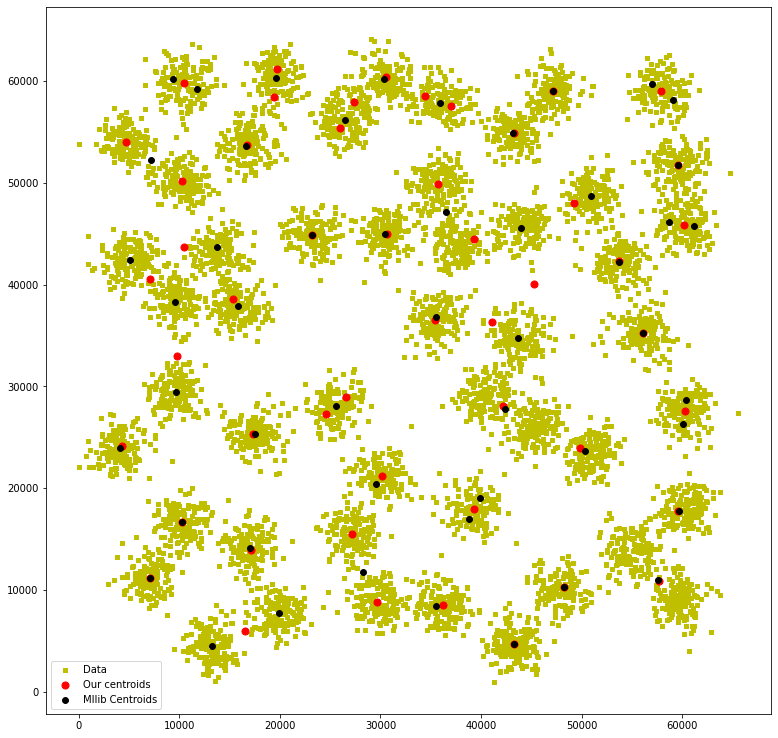

In [15]:
xdata, ydata = np.hsplit(array(parsed_data.collect()), 2)

x, y = np.hsplit(array(final_centroids), 2) 
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)


x1, y1 = zip(*mllib_clusters.centers)

data_scatter = ax1.scatter(xdata, ydata, s=10, color='y', marker="s")
our_centroids = ax1.scatter(x, y, s=50, color='r', marker="o")
mllib_centoids = ax1.scatter(x1, y1, s=35, color='k', marker="o")

plt.legend([data_scatter,our_centroids,mllib_centoids], ['Data', 'Our centroids', 'Mllib Centroids'])

***
## PKmeans evaluation on large sets
***

### KDD Cup 1999 data set
Load and clean the data set. <br>
Then, use built in spark stats to analize the data set.

In [16]:
kdd_data = sc.textFile("data/kddcup1999")
kdd_parsed_data = kdd_data.map(lambda line: line.strip().split(','))
kdd_parsed_data.cache()

PythonRDD[153] at RDD at PythonRDD.scala:53

In [17]:
kdd_fields = [  "duration",
                "protocol_type",
                "service",
                "flag",
                "src_bytes",
                "dst_bytes",
                "land",
                "wrong_fragment",
                "urgent",
                "hot",
                "num_failed_logins",
                "logged_in",
                "num_compromised",
                "root_shell",
                "su_attempted",
                "num_root",
                "num_file_creations",
                "num_shells",
                "num_access_files",
                "num_outbound_cmds",
                "is_host_login",
                "is_guest_login",
                "count",
                "srv_count",
                "serror_rate",
                "srv_serror_rate",
                "rerror_rate",
                "srv_rerror_rate",
                "same_srv_rate",
                "diff_srv_rate",
                "srv_diff_host_rate",
                "dst_host_count",
                "dst_host_srv_count",
                "dst_host_same_srv_rate",
                "dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate",
                "dst_host_serror_rate",
                "dst_host_srv_serror_rate",
                "dst_host_rerror_rate",
                "dst_host_srv_rerror_rate"
]

In [18]:
kdd_parsed_data.take(10)

[['0',
  'tcp',
  'http',
  'SF',
  '215',
  '45076',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '1',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '0',
  '0',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  'normal.'],
 ['0',
  'tcp',
  'http',
  'SF',
  '162',
  '4528',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '2',
  '2',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '1',
  '1',
  '1.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  'normal.'],
 ['0',
  'tcp',
  'http',
  'SF',
  '236',
  '1228',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '1',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '2',
  '2',
  '1.00',
  '0.00',
  

We will use only the numeric fields for clustering.

In [19]:
numeric_fields = [
    "duration",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
]

In [20]:
fields_filter = [1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
len(fields_filter)

42

In [21]:
def parse_kdd_line_filter_fields(line):
    split_line = line.strip().split(',')
    return array(list(map(float, compress(split_line, fields_filter))))
    
    
kdd_data = sc.textFile("data/kddcup1999")
kdd_parsed_data_clean = kdd_data.map(parse_kdd_line_filter_fields)
kdd_parsed_data_clean.cache()



PythonRDD[157] at RDD at PythonRDD.scala:53

In [22]:
sc.setLogLevel('INFO')

In [ ]:
kdd_centroids = pkmeans(kdd_parsed_data_clean, 150)
sc.show_profiles()

In [24]:
t = time.time()
mllib_clusters = KMeans.train(kdd_parsed_data_clean, 30, maxIterations=150, initializationMode="random")
mllib_clusters.centers
print("Took", time.time() - t, "seconds")

Took 262.4746928215027 seconds


In [25]:
rmstd_kdd_mllib = rmsstd(kdd_parsed_data_clean, mllib_clusters.centers)
rmstd_kdd_mllib

5.515787009157204